In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely
import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd


gdf = gpd.read_file('NJ City Shapefiles/cb_2018_34_cousub_500k.shp')
# Convert county FIPS codes to str
gdf['COUSUBNS'] = gdf['COUSUBNS'].astype(str)

In [2]:
gdf.shape

(565, 11)

In [3]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [4]:
gdf.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
AFFGEOID      object
GEOID         object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

In [5]:
# Specify columns of interest
gdf = gdf[['COUSUBFP','NAME','geometry']]
gdf.head()

,COUSUBFP,NAME,geometry
0,63850,Robbinsville,"POLYGON ((-74.64994 40.24176, -74.62104 40.249..."
1,67350,Shrewsbury,"POLYGON ((-74.07491 40.33727, -74.06909 40.337..."
2,34530,Island Heights,"POLYGON ((-74.15572 39.94746, -74.15372 39.947..."
3,83050,Wyckoff,"POLYGON ((-74.19029 40.99239, -74.18882 41.004..."
4,64410,Roosevelt,"POLYGON ((-74.48993 40.21676, -74.48472 40.220..."


In [6]:
FIPS = pd.read_csv('NJ_FIPS_codes.csv', header=None)

In [7]:
FIPS.head()

,0,1,2,3,4,5,6
0,NJ,34,1,Atlantic County,0,County subdivisions not defined,F
1,NJ,34,1,Atlantic County,100,Absecon city,F
2,NJ,34,1,Atlantic County,2080,Atlantic City city,F
3,NJ,34,1,Atlantic County,7810,Brigantine city,F
4,NJ,34,1,Atlantic County,8680,Buena borough,F


In [8]:
# Drop County subdivisions not defined
FIPS = FIPS[FIPS[5] != 'County subdivisions not defined']

# Select Columns of interest
FIPS = FIPS[[3,4,5]]

FIPS.head()

,3,4,5
1,Atlantic County,100,Absecon city
2,Atlantic County,2080,Atlantic City city
3,Atlantic County,7810,Brigantine city
4,Atlantic County,8680,Buena borough
5,Atlantic County,8710,Buena Vista township


In [9]:
FIPS.shape

(566, 3)

In [10]:
FIPS.dtypes

3    object
4     int64
5    object
dtype: object

In [11]:
# Rename columns
FIPS = FIPS.rename(columns={3:'County', 4: 'COUSUBFP', 5: 'City'})

# Convert COUSUBNS to string and pad with zeroes

FIPS['COUSUBFP'] = FIPS['COUSUBFP'].astype(str)

FIPS['COUSUBFP'] = FIPS['COUSUBFP'].apply(lambda x: x.zfill(5)).astype(str)

# Make City in Title Format

# Remove Repeated Word 'city' from City Column
FIPS['City'] = FIPS['City'].str.split(' city',expand=False)
FIPS['City'] = FIPS['City'].apply(lambda x: x[0])

FIPS['City'] = FIPS['City'].str.title()

FIPS.head()

,County,COUSUBFP,City
1,Atlantic County,00100,Absecon
2,Atlantic County,02080,Atlantic City
3,Atlantic County,07810,Brigantine
4,Atlantic County,08680,Buena Borough
5,Atlantic County,08710,Buena Vista Township


In [12]:
merge = FIPS.merge(gdf,how='inner',on='COUSUBFP')

# Drop NAME and COUSUBFP columns
merge.drop(['NAME','COUSUBFP'],axis=1,inplace=True)

# Add State Column
merge['State'] = 'New Jersey'

# Rearrange Columns

merge = merge[['State','County','City','geometry']]

In [13]:
merge.head()

,State,County,City,geometry
0,New Jersey,Atlantic County,Absecon,"POLYGON ((-74.53138 39.42627, -74.52287 39.435..."
1,New Jersey,Atlantic County,Atlantic City,"POLYGON ((-74.49956 39.35965, -74.49366 39.364..."
2,New Jersey,Atlantic County,Brigantine,"POLYGON ((-74.42199 39.38523, -74.41318 39.389..."
3,New Jersey,Atlantic County,Buena Borough,"POLYGON ((-74.98527 39.51497, -74.95626 39.540..."
4,New Jersey,Atlantic County,Buena Vista Township,"POLYGON ((-74.97183 39.50916, -74.94928 39.508..."


In [14]:
import pymssql

database = "Pushing-P-DB"
table = "dbo.Master_Table"
user = "pushing_p"
password  = "t3stP@ssword"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)


# Query select all rows from SQL table to insert in DataFrame
query = f'SELECT * FROM {table}'
master_table = pd.read_sql(query, conn)
master_table.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude
0,New Jersey,Bergen County,Ramsey Borough,2.3,156058,14915,259,11,11,0,...,159,100,199,4,0,4,0,52,41.062513,-74.135741
1,New Jersey,Monmouth County,Middletown Township,5.6,119013,65168,1821,21,88,191,...,1143,678,1326,225,46,119,0,0,40.392780,-74.099818
2,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,19,34,37,0,0,0,0,16,40.629903,-74.969181
3,New Jersey,Essex County,Maplewood Township,5.4,149568,25129,974,0,74,335,...,354,620,80,821,24,0,0,42,40.729979,-74.271992
4,New Jersey,Bergen County,Ridgefield Borough,6.2,79696,11209,1525,85,145,85,...,684,841,802,2,3,673,0,20,40.834267,-74.008750


In [15]:
# Merge Geodata with Master_table

df = master_table.merge(merge[['City','geometry']],how='inner',on=['City'])

# Convert to Geodataframe
df = gpd.GeoDataFrame(df, geometry=df['geometry'])

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100


df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude,geometry,% Uninsured
0,New Jersey,Bergen County,Ramsey Borough,2.3,156058,14915,259,11,11,0,...,199,4,0,4,0,52,41.062513,-74.135741,"POLYGON ((-74.17616 41.05181, -74.17315 41.054...",1.736507
1,New Jersey,Monmouth County,Middletown Township,5.6,119013,65168,1821,21,88,191,...,1326,225,46,119,0,0,40.392780,-74.099818,"MULTIPOLYGON (((-74.02076 40.47522, -74.01838 ...",2.794316
2,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,37,0,0,0,0,16,40.629903,-74.969181,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",1.121456
3,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,37,0,0,0,0,16,40.629903,-74.969181,"POLYGON ((-74.31176 40.69007, -74.30893 40.690...",1.121456
4,New Jersey,Union County,Union Township,5.2,95489,58355,3879,45,339,583,...,1379,1106,0,311,0,835,40.697590,-74.263163,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",6.647245


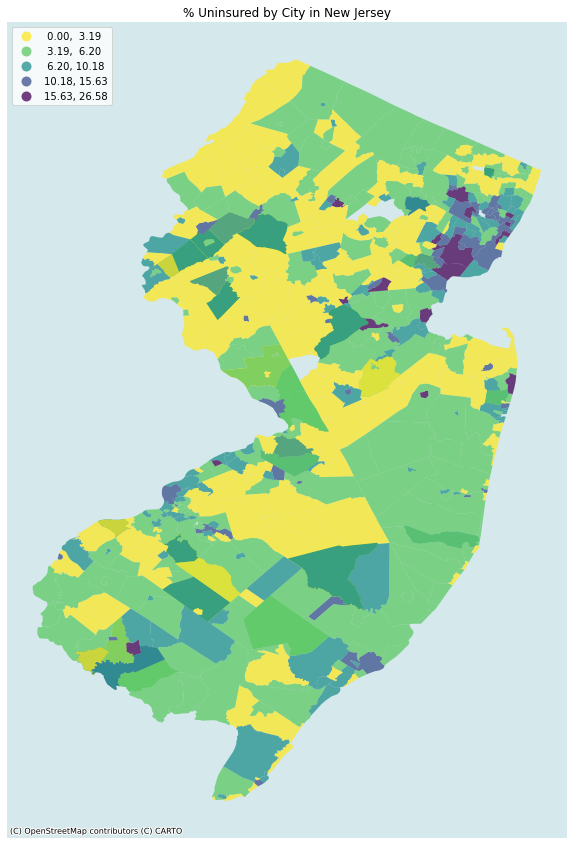

In [16]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=df.crs, 
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes

plt.title('% Uninsured by City in New Jersey')
ax.set_axis_off();

plt.savefig('output.png')